In [0]:
!pip install -q keras

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**In this notebook we train a resnet model om cifar10 dataset and cut-out/random erasing image augmentation.**

## Loading and preprocessing data

In [3]:
import numpy as np
from keras.datasets import cifar10
import keras
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_test_unchanged=x_test.copy()
subtract_pixel_mean=True
num_classes=10

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
BATCH_SIZE=1024
epochs=200


## One Cycle Policy

In [0]:
import os
import numpy as np
import warnings

from keras.callbacks import Callback
from keras import backend as K


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 max_lr,
                 end_percentage=0.1,
                 scale_percentage=None,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.

        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.

        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")

        if scale_percentage is not None and (scale_percentage < 0. or scale_percentage > 1.):
            raise ValueError("`scale_percentage` must be between 0 and 1")

        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = float(scale_percentage) if scale_percentage is not None else float(end_percentage)
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = None
        self.batch_size = None
        self.samples = None
        self.steps = None
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.

        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.

        # Returns:
            the new learning rate
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            current_percentage = (self.clr_iterations - 2 * self.mid_cycle_id)
            current_percentage /= float((self.num_iterations - 2 * self.mid_cycle_id))
            new_lr = self.initial_lr * (1. + (current_percentage *
                                              (1. - 100.) / 100.)) * self.scale

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - (
                self.clr_iterations - self.mid_cycle_id) / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        else:
            current_percentage = self.clr_iterations / self.mid_cycle_id
            new_lr = self.initial_lr * (1. + current_percentage *
                                        (self.scale * 100 - 1.)) * self.scale

        if self.clr_iterations == self.num_iterations:
            self.clr_iterations = 0

        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.

        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.

        # Returns:
            the new momentum value
        """
        if self.clr_iterations > 2 * self.mid_cycle_id:
            new_momentum = self.max_momentum

        elif self.clr_iterations > self.mid_cycle_id:
            current_percentage = 1. - ((self.clr_iterations - self.mid_cycle_id) / float(
                                        self.mid_cycle_id))
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        else:
            current_percentage = self.clr_iterations / float(self.mid_cycle_id)
            new_momentum = self.max_momentum - current_percentage * (
                self.max_momentum - self.min_momentum)

        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}
        
        #print(self.params.keys())
        self.epochs = self.params['epochs']
        self.batch_size = BATCH_SIZE #self.params['batch_size']
        self.samples =100000 #self.params['samples']
        self.steps = self.params['steps']

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))



## Resnet Builder  



In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation,GlobalAveragePooling2D
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

import numpy as np
import os

class ResnetBuilder():
  def __init__(self):
    self.fgh=3
    
    
  
  @classmethod
  def resnet_layer(self,
                   inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

  @classmethod
  def resnet_v1(self,input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = self.resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = self.resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = self.resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = self.resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    

   #removing dense layer.added GAP
    
    x=Conv2D(num_classes,
                  kernel_size=(1,1),
                  strides=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x=GlobalAveragePooling2D(data_format='channels_last')(x)
    outputs=Activation('softmax')(x)


    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

    
  @classmethod  
  def resnet_v2(self,input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = self.resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = self.resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = self.resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = self.resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = self.resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = AveragePooling2D(pool_size=8)(x)
#     y = Flatten()(x)
#     outputs = Dense(num_classes,
#                     activation='softmax',
#                     kernel_initializer='he_normal')(y)
    x=Conv2D(num_classes,
                  kernel_size=(1,1),
                  strides=(1,1),
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    x=GlobalAveragePooling2D(data_format='channels_last')(x)
    outputs=Activation('softmax')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

  @classmethod  
  def build_resnet(self,n,version,input_shape, num_classes):
    
    # Model version
    # Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
    
    # Computed depth from supplied model parameter n
    if version == 1:
      depth = n * 6 + 2
    elif version == 2:
      depth = n * 9 + 2

    # Model name, depth and version
    model_type = 'ResNet%dv%d' % (depth, version)
    
    if version == 2:
      model = self.resnet_v2(input_shape=input_shape, depth=depth,num_classes=num_classes)
    else:
      model = self.resnet_v1(input_shape=input_shape, depth=depth,num_classes=num_classes)

    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    return model
  
  

## Creating resnet model

In [14]:
builder=ResnetBuilder()
model=builder.build_resnet(n=3,version=1,input_shape=input_shape, num_classes=10)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 32, 32, 16)   64          conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 32, 32, 16)   0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
conv2d_24 

In [0]:
filepath="/content/gdrive/My Drive/EIP/Phase2/Assignment1/July_03/epochs_001_200:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_weights_only=False,
                             save_best_only=False,
                             mode='max',
                             period=10)
lr_manager = OneCycleLR(max_lr=0.03,end_percentage=0.1, maximum_momentum=0.9,minimum_momentum=0.8, verbose=True)

callbacks = [checkpoint, lr_manager]
   

## Image Augmentation uisng cut-out/random-erasing

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser


In [0]:
pixel_level = True
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))


## Trainig the model

In [0]:
datagen.fit(x_train)

In [19]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                        validation_data=(x_test, y_test),
                        epochs=epochs, 
                        verbose=1, 
                        workers=4,
                        steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
                        callbacks=callbacks)


W0703 05:01:01.838740 139905520752512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
48/48 [==============================] - 31s 636ms/step - loss: 2.7628 - acc: 0.1379 - val_loss: 2.3121 - val_acc: 0.1962
 - lr: 0.00329 - momentum: 0.90 
Epoch 2/200
48/48 [==============================] - 25s 518ms/step - loss: 2.2099 - acc: 0.2330 - val_loss: 2.1587 - val_acc: 0.2440
 - lr: 0.00359 - momentum: 0.90 
Epoch 3/200
48/48 [==============================] - 25s 523ms/step - loss: 2.0667 - acc: 0.2908 - val_loss: 2.0458 - val_acc: 0.2876
 - lr: 0.00389 - momentum: 0.90 
Epoch 4/200
48/48 [==============================] - 25s 523ms/step - loss: 1.9726 - acc: 0.3241 - val_loss: 1.9380 - val_acc: 0.3368
 - lr: 0.00419 - momentum: 0.90 
Epoch 5/200
48/48 [==============================] - 25s 519ms/step - loss: 1.9026 - acc: 0.3515 - val_loss: 1.8529 - val_acc: 0.3672
 - lr: 0.00449 - momentum: 0.89 
Epoch 6/200
48/48 [==============================] - 25s 520ms/step - loss: 1.8535 - acc: 0.3709 - val_loss: 1.8118 - val_acc: 0.3783
 - lr: 0.00479 - momentum: 0.89

In [20]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 155us/step
Test loss: 0.5414112634658813
Test accuracy: 0.8628


## Loading the pre trained model

In [0]:
builder=ResnetBuilder()
model_pretrained=builder.build_resnet(n=3,version=1,input_shape=input_shape, num_classes=10)
#model_pretrained.load_weights("/content/gdrive/My Drive/EIP/Phase2/Assignment1/July_01/epochs_001_200:200-val_acc:0.876.hdf5")
model_pretrained.load_weights("/content/gdrive/My Drive/EIP/Phase2/Assignment1/July_03/epochs_001_200:200-val_acc:0.863.hdf5")
model_pretrained.compile(loss = 'categorical_crossentropy',
                    optimizer = 'sgd',
                    metrics = ['accuracy'])

In [22]:
model_pretrained.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 32, 32, 16)   64          conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 32, 32, 16)   0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_46 

In [23]:
conv_layer_names=[layer.name for layer in model_pretrained.layers if 'conv2d_' in layer.name]
conv_layer_names

['conv2d_45',
 'conv2d_46',
 'conv2d_47',
 'conv2d_48',
 'conv2d_49',
 'conv2d_50',
 'conv2d_51',
 'conv2d_52',
 'conv2d_53',
 'conv2d_54',
 'conv2d_55',
 'conv2d_56',
 'conv2d_57',
 'conv2d_58',
 'conv2d_59',
 'conv2d_60',
 'conv2d_61',
 'conv2d_62',
 'conv2d_63',
 'conv2d_64',
 'conv2d_65',
 'conv2d_66']

In [24]:
last_conv_layer=conv_layer_names[len(conv_layer_names)-1]
last_conv_layer

'conv2d_66'

In [25]:
scores = model_pretrained.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 266us/step
Test loss: 0.5414112682819366
Test accuracy: 0.8628


## Finding 50 misclassified images

In [0]:
y_prediction=model_pretrained.predict(x_test)
y_prediction_class=[np.argmax(probs) for probs in y_prediction]
y_test_class=[np.argmax(probs) for probs in y_test]

In [0]:
misclassified_img_indices=[]
for i in range(0,len(y_prediction_class)):
  if(y_prediction_class[i]!=y_test_class[i]):
    misclassified_img_indices.append(i)

## Creating a gallery of the misclassified images

In [0]:
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE=32
NUM_CHANNELS=3

def plot_objects(instances, images_per_row=10, **options):
    size = IMAGE_SIZE
    images_per_row = min(len(instances), images_per_row)
    images = [instance.astype("uint8").reshape(size,size,NUM_CHANNELS) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(9,9))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.show()

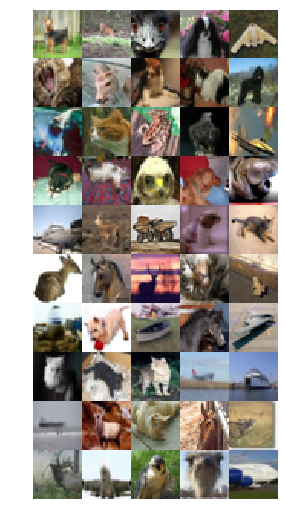

In [29]:
plot_objects(x_test_unchanged[misclassified_img_indices[0:50]],images_per_row=5)

## Gradcam

In [0]:
import keras.backend as K
import numpy as np
import cv2
import sys

def grad_cam_output(img_processed,img_original,model,conv_layer_nm=last_conv_layer):
  x = np.expand_dims(img_processed, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(conv_layer_nm)
  
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  img = img_original

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = cv2.addWeighted(np.asarray(img, np.float64), 0.6, 
                                   np.asarray(heatmap, np.float64), 0.4, 0)
  return np.asarray(superimposed_img, np.int32)
  

In [0]:
gradcam_outputs=[]
for i in misclassified_img_indices[0:50]:
  gradcam_outputs.append(grad_cam_output(x_test[i],x_test_unchanged[i],model_pretrained))


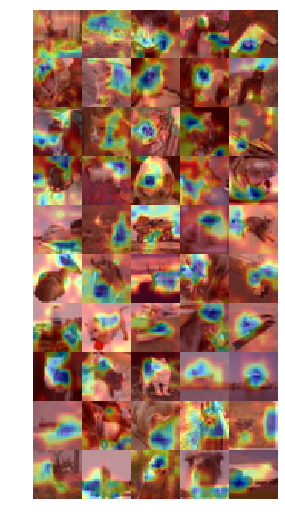

In [32]:
plot_objects(gradcam_outputs[0:50],images_per_row=5)